In [155]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from tqdm import tqdm
from sklearn import preprocessing
import talib

sys.path.append('../Runs')
from train_QTable import optimal_strategy, optimal_strategy_fixedStepsize, run
from train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples
from helper.Q_learning import round_custombase
from helper.manage_orderbooks import OrderbookEpisodesGenerator, plot_episode, convert_actions_to_limit
from helper.orderbook_trader import OrderbookTradingSimulator
from agents.QTable_Agent import QTable_Agent
from agents.BatchTree_Agent import RLAgent_BatchTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0


In [4]:
data_nov_orig = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
for window in data_nov_orig:
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_nov_orig), data_nov_orig[0][0])

20

OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -spread: 0.4509970000000294
  -future15: -3.246150348523713e-08
  -future15_disc: 2.0
  -future30: -0.0006393032568402512
  -future30_disc: 2.0
  -future45: -0.0025756666407984463
  -future45_disc: 1.0

In [ ]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print("loaded")
for window in tqdm(data_feb[:20]):
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_feb), data_feb[0][0])

In [5]:
data_selection = [data_nov_orig[x] for x in [0,17]]
print(len(data_selection))
print(data_selection[0][0].timestamp)
print(data_selection[1][0].timestamp)

2
2016-11-08T10:00
2016-11-09T03:01


In [6]:
convert_actions_to_limit(data_selection[0], actions=[1,2,3])

limits [705.93069993997915, 706.63592541444473, 706.63592541444473]


[705.93069993997915, 706.63592541444473, 706.63592541444473]

In [ ]:
plot_episode(data_selection[0], actions=[1, 3])
plot_episode(data_selection[0], actions=[1, 3, 4])


In [ ]:
#plot_episode(data_selection[1], limits=[714.843016, 714.843016, 719.106494])
plot_episode(data_selection[1], actions=[6,4,6])
plot_episode(data_selection[1], actions=[5,4,6])


In [157]:
experiment_name='individual_window'
folder='experiments'
outputfile_agent=os.path.join(folder, experiment_name, 'model', experiment_name)
outputfile_agent='q.json'
outputfile_samples='q.csv'
volume=70000
consume='cash'
volume_intervals=10
decision_points=3
period_length=20
actions = list(range(-4,11))

state_variables=['volume','time']
limit_base = 'incStepUnits' # 'curr_ask', 'init_center', 'incStepUnits'
#
## crescending
#episodes_train = data_nov_orig[17:18]
#print(actions)
#print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
#ql_cresc, limits = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
#                                                  consume=consume, period_length=period_length,
#                                                  vol_intervals=volume_intervals,
#                              actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables, 
#                              outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                              limit_base=limit_base, interpolate_vol=False)

# # # even
# episodes_train = data_nov_orig[0:1]
# print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
# 
# ql_even, limits_even = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
#                                                       consume=consume, period_length=period_length, 
#                                                       vol_intervals=volume_intervals,
#                           actions=actions, lim_stepsize=0.1, state_variables=state_variables, 
#                           outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                           limit_base=limit_base, interpolate_vol=False)

# episodes_train = data_selection
# print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
# ql_both, limits_both = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
#                                                       consume=consume, period_length=period_length,
#                                                       vol_intervals=volume_intervals,
#                           actions=actions, lim_stepsize=0.1, state_variables=state_variables, 
#                           outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                           limit_base=limit_base, interpolate_vol=False)

episodes_train = data_nov_orig
print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
ql_all, limits_both = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
                                                      consume=consume, period_length=period_length,
                                                      vol_intervals=volume_intervals,
                          actions=actions, lim_stepsize=0.1, state_variables=state_variables, 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base, interpolate_vol=False)

Window len 20 2016-11-08T10:00
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>
time_left 1


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0



The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
time_left 2
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


time_left 3
cash, volume 70000 0
Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'
cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


cash, volume 70000 0


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Saved agent: 'q.json'
Saved samples: 'q.csv'



In [162]:
ql_all.save(outfile_agent='ql_all.json', outfile_samples='ql_all.csv')

Saved agent: 'ql_all.json'
Saved samples: 'ql_all.csv'


In [ ]:
print(volume_intervals)
episodes_train = data_nov_orig
print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
ql_20_cheat, limits_both = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
                          period_length=period_length, vol_intervals=volume_intervals,
                          actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables + ['future15_disc'], 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base, interpolate_vol=False)

In [114]:
print(ql_cresc.q.keys())
#print(ql_cresc.q.get('[  5.00000000e+04   1.00000000e+00]'))
print(ql_cresc.q.get('[  5.00000000e+04   2.00000000e+00]'))

dict_keys(['[  5.00000000e+04   1.00000000e+00]', '[  4.50000000e+04   1.00000000e+00]', '[  4.00000000e+04   1.00000000e+00]', '[  3.50000000e+04   1.00000000e+00]', '[  3.00000000e+04   1.00000000e+00]', '[  2.50000000e+04   1.00000000e+00]', '[  2.00000000e+04   1.00000000e+00]', '[  1.50000000e+04   1.00000000e+00]', '[  1.00000000e+04   1.00000000e+00]', '[  5.00000000e+03   1.00000000e+00]', '[  5.00000000e+04   2.00000000e+00]', '[  4.50000000e+04   2.00000000e+00]', '[  4.00000000e+04   2.00000000e+00]', '[  3.50000000e+04   2.00000000e+00]', '[  3.00000000e+04   2.00000000e+00]', '[  2.50000000e+04   2.00000000e+00]', '[  2.00000000e+04   2.00000000e+00]', '[  1.50000000e+04   2.00000000e+00]', '[  1.00000000e+04   2.00000000e+00]', '[  5.00000000e+03   2.00000000e+00]', '[  5.00000000e+04   3.00000000e+00]'])
[          nan           nan           nan           nan           nan
           nan  209.63369217  209.63369217  168.06641061   97.26929062
   68.82769498   37.5716235

21


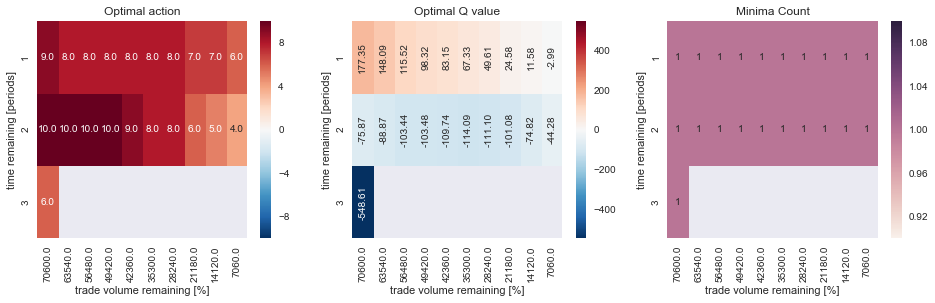

21


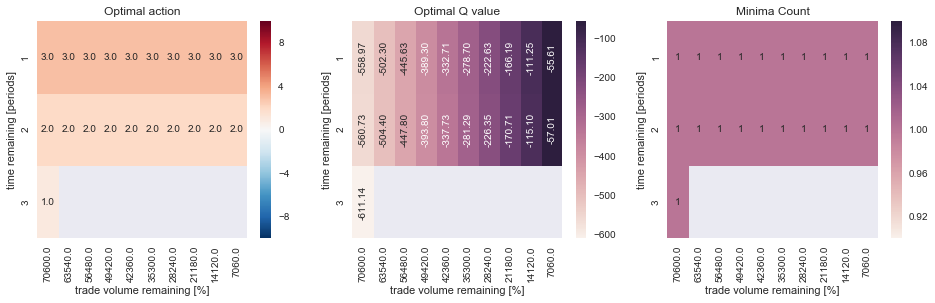

21


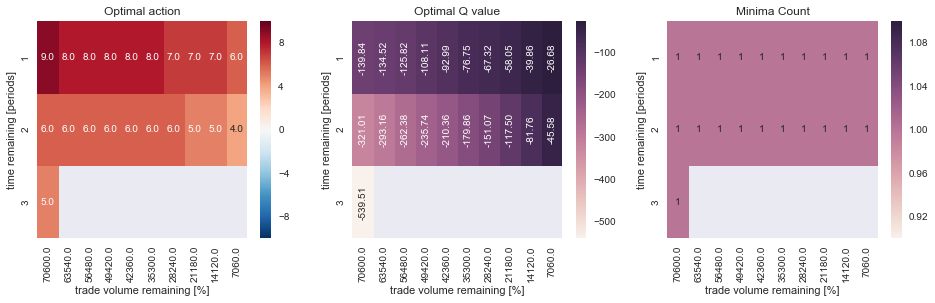

21


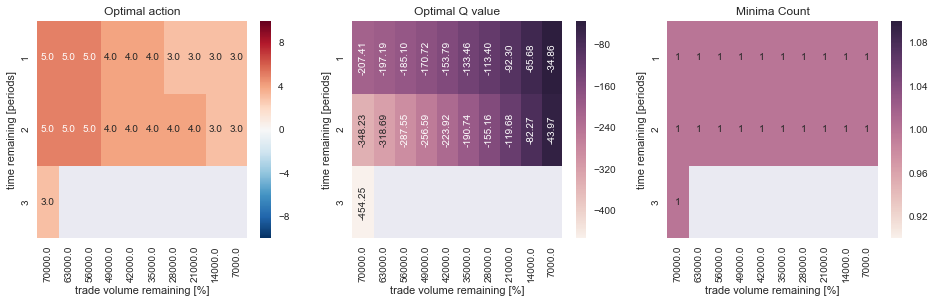

In [160]:
print(len(ql_cresc.q.keys()))
ql_cresc.heatmap_Q(show_minima_count=True)
print(len(ql_even.q.keys()))
ql_even.heatmap_Q(show_minima_count=True)
print(len(ql_both.q.keys()))
ql_both.heatmap_Q(show_minima_count=True)
print(len(ql_all.q.keys()))
ql_all.heatmap_Q(show_minima_count=True)

limits [706.63592541444473, nan, nan]


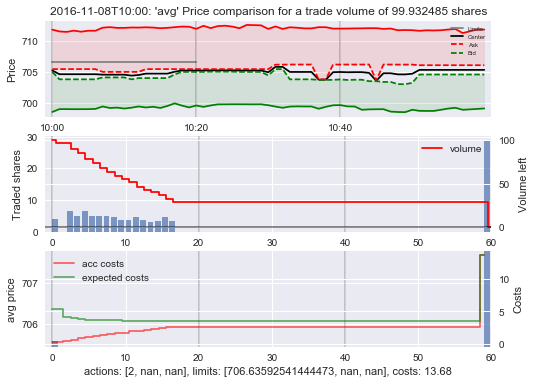

limits [709.4568273123067, nan, nan]


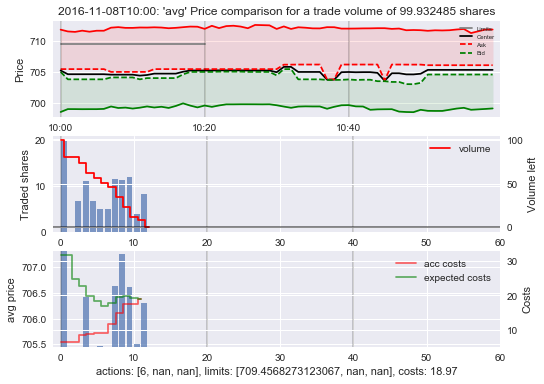

In [145]:
plot_episode(data_nov_orig[0], actions=[2, np.nan, np.nan], volume=99.932485)
plot_episode(data_nov_orig[0], actions=[6, np.nan, np.nan], volume=99.932485)

In [161]:
ql_all.samples

,volume,time,action,action_idx,cost,avg,initial_center,timestamp,volume_n,time_n
0,70000.0,1.0,-4.0,0,2.055560,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
1,70000.0,1.0,-3.0,1,2.055560,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
2,70000.0,1.0,-2.0,2,2.055560,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
3,70000.0,1.0,-1.0,3,2.055553,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
4,70000.0,1.0,0.0,4,2.055553,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
5,70000.0,1.0,1.0,5,2.055553,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
6,70000.0,1.0,2.0,6,2.055553,711.78814,705.225474,2016-11-08 10:40:00,0.00,0.0
7,70000.0,1.0,3.0,7,-551.487842,706.15966,705.225474,2016-11-08 10:40:00,0.00,0.0
8,70000.0,1.0,4.0,8,-510.918049,706.57217,705.225474,2016-11-08 10:40:00,0.00,0.0
9,70000.0,1.0,5.0,9,-489.426946,706.79070,705.225474,2016-11-08 10:40:00,0.00,0.0


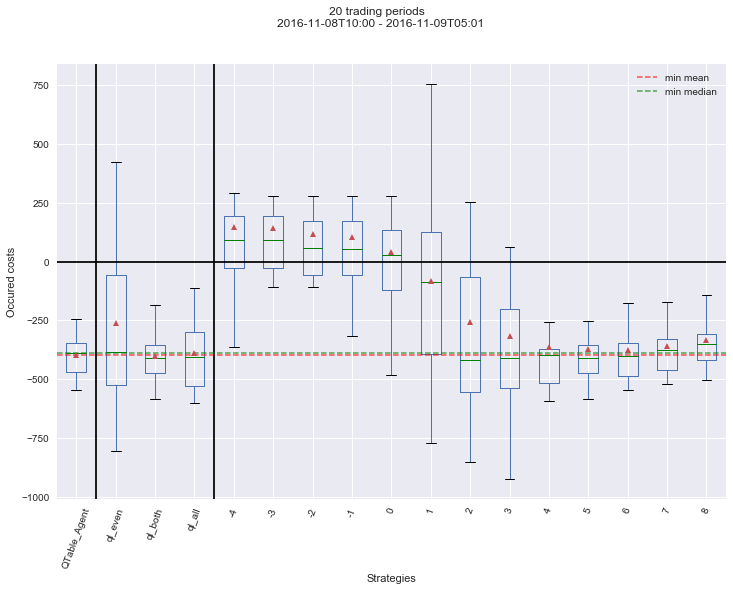

,QTable_Agent,ql_even,ql_both,ql_all,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-395.888389,-262.402276,-403.238536,-388.028133,148.464101,143.088219,118.333449,104.352090,38.996701,-81.587884,-255.194472,-315.509165,-362.426952,-370.021050,-375.536924,-359.495944,-333.053969
std,166.775923,370.822038,206.743831,248.898304,332.169345,333.381219,354.695083,369.196521,408.097646,474.315779,452.168200,403.512993,362.398866,312.285713,254.742529,229.711079,194.306194
min,-826.361474,-805.132825,-905.332913,-925.211217,-361.930377,-392.155481,-585.168354,-620.277305,-559.560870,-769.044814,-853.219425,-925.211217,-915.490004,-905.332913,-826.361474,-790.968543,-661.439861
25%,-467.535175,-522.481783,-475.336601,-529.041865,-28.809186,-28.809186,-55.263277,-55.263277,-122.569477,-391.886770,-556.352271,-538.599323,-514.433867,-475.336601,-488.255591,-461.791366,-418.584242
50%,-388.901371,-386.048944,-408.074238,-404.868364,90.768894,90.768894,55.636272,55.209733,28.092329,-86.769795,-418.554317,-408.590288,-397.746659,-411.346581,-399.962507,-375.632513,-351.795373
75%,-344.576670,-55.583140,-352.973198,-300.597911,194.685149,193.250147,171.731781,171.731781,135.457928,127.428139,-64.212748,-202.060265,-369.809926,-352.973198,-344.576670,-330.945203,-307.233705
max,8.803629,673.169858,221.892800,356.808148,1218.789144,1218.789144,1218.789144,1218.789144,1218.789144,1218.789144,1218.695428,1078.443414,994.126825,791.658786,546.385944,443.805337,316.032640
rel_mean,1.000000,0.662819,1.018566,0.980145,-0.375015,-0.361436,-0.298906,-0.263590,-0.098504,0.206088,0.644612,0.796965,0.915478,0.934660,0.948593,0.908074,0.841282
rel_median,1.000000,0.992665,1.049300,1.041057,-0.233398,-0.233398,-0.143060,-0.141963,-0.072235,0.223115,1.076248,1.050627,1.022744,1.057714,1.028442,0.965881,0.904588


,QTable_Agent,ql_even,ql_both,ql_all,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8
2016-11-08T10:00,-527.432247,-610.924004,-531.348637,-573.931847,2.055639,2.055639,-8.171375,-8.171375,-8.169712,-574.301591,-610.924493,-573.931847,-553.970285,-531.348637,-527.432247,-516.087460,-419.688737
2016-11-08T11:01,-502.258444,-110.329232,-505.701301,-527.855281,131.970586,131.970586,131.970586,131.970586,131.948822,131.948822,-434.708361,-527.855281,-509.647693,-505.701301,-502.258444,-489.871283,-482.664940
2016-11-08T12:01,-435.102448,-78.109386,-454.432326,-532.601619,25.598432,25.598432,22.381852,22.381852,22.381852,22.371354,-549.695628,-532.601619,-528.792389,-454.432326,-435.102448,-386.877472,-381.091140
2016-11-08T13:01,-423.955622,11.995598,-413.364327,-289.079507,218.182942,218.182942,218.182942,218.182942,104.429604,104.429604,-94.249810,-125.362420,-390.683583,-422.394031,-454.629721,-423.895800,-406.583181
2016-11-08T14:01,-136.883944,28.130571,-184.422249,-150.622672,166.691524,166.691524,166.691524,166.691524,166.691524,155.418976,80.497932,62.874823,-11.870325,-117.487257,-174.433582,-211.751681,-215.880877
2016-11-08T15:01,-246.100012,-195.071004,-248.152554,-246.253479,279.297745,279.297745,279.297745,279.297745,279.297745,275.042590,251.845741,-105.481713,-258.333800,-250.843264,-246.100012,-173.611930,-165.273068
2016-11-08T16:01,-320.032092,-512.632583,-335.635077,-371.504248,-361.930377,-392.155481,-585.168354,-620.277305,-559.560870,-484.244498,-388.266962,-371.504248,-353.277717,-335.635077,-320.032092,-303.142721,-142.211435
2016-11-08T17:01,-337.118587,-365.338138,-352.773423,-304.437378,33.802805,33.802805,33.802805,33.802805,33.802805,-101.346292,-112.717162,-231.641233,-390.681304,-352.773423,-337.118587,-334.425404,-316.585063
2016-11-08T18:01,-347.062698,-334.788984,-353.039789,-353.918206,-62.340231,-62.340231,-62.340231,-62.340231,-62.344194,-72.193298,-73.347815,-227.626213,-385.371373,-353.039789,-347.062698,-337.946757,-315.741966
2016-11-08T19:01,-356.502234,100.324401,-365.008408,-402.042235,146.004841,146.004841,146.004841,146.004841,145.985246,125.921245,-36.807547,-401.643979,-375.320663,-365.008408,-356.502234,-320.504600,-307.405756


In [159]:
print("### cresc ###")
result_cresc = ql_cresc.evaluate(data_nov_orig,
            additional_agents={'ql_even': ql_even,
                               'ql_both': ql_both,
                               'ql_all': ql_all},
            evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            verbose=True,
            show_plot=True)
display(result_cresc)

In [ ]:
print("### cresc ###")
result_cresc2 = ql_cresc.evaluate(data_selection[:2],
            evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            custom_strategies={'4,6,4': [4,6,4],
                               '5,6,4': [5,6,4],
                              '6,4,6': [6,4,6],
                              '6,5,6': [6,5,6],
                              '7,4,6': [7,4,6]},
            verbose=True,
            show_plot=True)
display(result_cresc)
display(result_cresc2)

# print("### even ###")
# results_even = ql_even.evaluate(data_nov_orig[0:1],
#             evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
#             verbose=True)
# display(results_even)

In [ ]:
plot_episode(data_selection[1], limits=[714.843016, 714.843016, 719.106494])
#plot_episode(data_selection[1], limits=[715.553596])



In [ ]:
print("### both ###")
results_all = ql_both.evaluate(data_nov_orig[:],
            evaluate_actions=range(-1,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            additional_agents={'ql_cresc': ql_cresc,
                               'ql_even': ql_even,
                               'ql_20': ql_20,
                               'ql_20_cheat': ql_20_cheat,
                               'VolTime': agent_BatchTree['VolTime'],
                               'VolTimeFuturedisc15': agent_BatchTree['VolTimeFuturedisc15']},
            verbose=False,
           show_plot=True)
#display(results_all)

In [ ]:
print("### both ###")
results_all_feb = ql_both.evaluate(data_feb[:20],
            evaluate_actions=[6],  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            additional_agents={'ql_cresc': ql_cresc,
                               'ql_even': ql_even,
                               'ql_20': ql_20,
                               'ql_20_cheat': ql_20_cheat,
                               'VolTime': agent_BatchTree['VolTime'],
                               'VolTimeFuturedisc15': agent_BatchTree['VolTimeFuturedisc15']},
            verbose=False,
           show_plot=True)
#display(results_all)

In [ ]:
df = ql_20.samples
def addMarketFeatures_toSamples(samples_df, hist, state_variables,
                                market_features, period_length=15):
    df = samples_df.copy()
    
    for i, f in tqdm(enumerate(market_features)):
        #
        f_n = "{}_n".format(f)
        if f in df.columns:
            df.drop(f, inplace=True, axis=1)
        if f_n in df.columns:
            df.drop(f_n, inplace=True, axis=1)
        
        df.insert(loc=2+i, column=f, value=df.timestamp.map(hist[f]),
                 allow_duplicates=True)
        df.insert(loc=df.shape[1],
                  column=f_n,
                  allow_duplicates=True,
                  value=(df.timestamp+pd.Timedelta(minutes=period_length)).map(hist[f]))
        if f not in state_variables:
            state_variables.append(f)

        if f in ['high24hr', 'low24hr', 'spread']:
            df[f] = df[f] / df.initial_center
            df[f_n] = df[f_n] / df.initial_center

    return df

df2 = addMarketFeatures_toSamples(samples_df=df, hist=hist, state_variables=state_variables,
                                 market_features=['future15', 'future15_disc', 'future30_disc', 'future45_disc'])
print(df2.shape)
display(df2.describe())

In [ ]:
actions = list(np.linspace(action_min, action_max, num=action_count))
actions = [round(a, 2) for a in actions]
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    'VolTime': ['volume', 'time'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
#    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    # 'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']
    'VolTimeFuturedisc15': ['volume', 'time', 'future15_disc']
}

agent_BatchTree = {}
for i, key in enumerate(experiments.keys()):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=10
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)))

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)), limits=[episodes_train[1][0].get_center()*1.002])

In [ ]:
print("both")
ql.heatmap_Q(show_minima_count=True)
print("even")
ql_even.heatmap_Q(show_minima_count=True)
print("cresc")
ql_cresc.heatmap_Q(show_minima_count=True)



In [ ]:
agent_BatchTree['VolTime_20samples'].samples

In [ ]:
ql.limit_base = 'incStepUnits'
ql_even.limit_base = 'incStepUnits'
ql_cresc.limit_base = 'incStepUnits'
evaluation = ql.evaluate(data_nov[17:18],
                      additional_agents={
                          'ql_even': ql_even,
                          'ql_cresc':ql_cresc},
                      evaluate_actions=[0.4, 0.5, 0.6, 0.7, 0.8], verbose=True,
                      show_plot=True,
                      )
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.volumes = ql.volumes[:4]
print(ql.volumes)

ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = True
ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = False

agent_BatchTree['VolTime_4I'].heatmap_Q()

In [ ]:
ql.interpolate_vol = True
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], verbose=False)
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.interpolate_vol = False
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
                      verbose=False)
#display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
display((evaluation / 52.069724).mean())
ql.plot_evaluation_costs(evaluation.iloc[10:,:], hline='0.4', showfliers=False, ylim=(0,80))

In [ ]:
#df2 = ql.samples
actions = list(np.linspace(action_min, action_max, num=action_count))
actions = [round(a, 2) for a in actions]
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    'VolTime_4I': ['volume', 'time'],
    'VolTime_4I_3vars': ['volume', 'time', 'future15_disc'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
#    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    # 'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']
    #'VolTimeFuturedisc15_20samples': ['volume', 'time', 'future15_disc']
}

#agent_BatchTree = {}
for i, key in enumerate(experiments.keys()):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=10
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)

In [ ]:
plot_episode(data_nov_orig[0], kind='worst')
plot_episode(data_nov_orig[0], kind='avg')
plot_episode(data_nov_orig[17], kind='worst')
plot_episode(data_nov_orig[17], kind='avg')

# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='worst')
# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='avg')
# plot_episode(data_nov_orig[17], limits=[1.005], intervals=4)
# #plot_episode(data_nov[17], limits=[1.005, 1.005, 1.005, 1.005], intervals=4)

In [ ]:
ql17_60decisions.limit_base = 'init_center'
ql17_60decisions.heatmap_Q()
display(ql17_60decisions.evaluate(data_nov[17:18]))
ql17_60decisions.limit_base = 'curr_ask'
display(ql17_60decisions.evaluate(data_nov[17:18]))

ql17.heatmap_Q()
display(ql17.evaluate(data_nov[17:18]), limit_base='curr_ask')

In [ ]:
for val in ql17_spread.samples.spread.unique():
    print("{:1.6f}".format(val))

In [ ]:
agent = ql17
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q()

agent = ql17_
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_15decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_60decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

In [ ]:
eval_costs = ql.evaluate(data_nov[17:18], additional_agents={'ql17_':ql17_, 'ql17_15decisions':ql17_15decisions}, show_plot=True)
display(eval_costs)
display(eval_costs.mean())

In [ ]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    # "../../../../data/history/history_2016-12_USDT_BTC.csv",
    # "../../../../data/history/history_2017-01_USDT_BTC.csv",
    # "../../../../data/history/history_2017-02_USDT_BTC.csv"
]

hist = load_and_preprocess_historyfiles(files=histfiles)
display(hist.describe())
display(hist.head())

In [ ]:
state_variables = ['volume', 'time', 'spread', 'future15', 'future30', 'future45']
print("state_variables", state_variables)
# add features to orderbooks

for window in tqdm(data_nov):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        # queue.append(ob)
        # if len(queue) == period_length:
        #     
        #     diffs = list(map(lambda t: queue[t].compare_with(queue[t-1]), range(1,len(queue))))
        #     
        #     neg = np.array([d.asks[d.asks<0].sum() for d in diffs]).sum()
        #     pos = np.array([d.asks[d.asks>0].sum() for d in diffs]).sum()
        #     
        #     ob.features['act15neg'] = neg
        #     ob.features['act15pos'] = pos
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
       
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
        
        for var in state_variables[2:]:
            ob.features[var] = market_features[var][-1]
            
print(data_nov[0][0])
print(data_nov[10][0])